In [1]:
import sys
sys.path.append('../..')
sys.path.append('../../util')
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import namedtuple

from tifffile import imsave, imread
from util.Grapher import Grapher
from util.ImageGenerator import ImageGenerator
from util.ImageDrawer import ImageDrawer
from util.helper import (
    bound_check,
    set_rgb
)

from scipy import ndimage, signal

FARSIGHT_DIR = "./FARSIGHT/"
IMG_DIR = './img/'
CENTERS_DIR = './centers/'
THRESHOLD = 15
Images = [
    'blurred_147_cells.tif'
    's3617_cutout.tif'
    'solid_45_cells_noise_random_intensity.tif'
]

In [2]:
def normalize(img):
    img_max = np.amax(img)
    img_min = np.amin(img)
    img = np.subtract(img, img_min)
    img = np.divide(img, img_max - img_min)
    return img
    

In [3]:
# Read in the image
orig_img = imread(IMG_DIR + 'blurred_147_cells.tif')
print("Tif img shape: {}".format(orig_img.shape))
grey_orig_img = orig_img[:,:,:,0]
normalized_img = normalize(grey_orig_img)
print("Normalized value: {}".format(np.amax(normalized_img)))

# Since our image stack is so big, we're going to break it up:
z_range, y_range, x_range = normalized_img.shape
image_stack = []
for i in range(10):
    image_stack.append(normalized_img[:, (i*100):((i+1)*100), (i*100):((i+1)*100)])
print("Images: {} of size {}".format(len(image_stack), image_stack[0].shape))

Tif img shape: (100, 1000, 1000, 3)
Normalized value: 1.0
Images: 10 of size (100, 100, 100)


In [13]:
# DoG approximation
def DoG(img, gamma = 2, dark = 1, print_level = 0):
    # if the image has white blobs then invert them to being dark blobs
    if not dark:
        img = 1 - img
        
    # Differential difference
    a = 0.01
    DoG_stack = []
    for sigma in np.linspace(2, 10, 10):
        if print_level:
            print("Sigma: {}".format(sigma))
        scale_constant = np.power(sigma, gamma - 1)
        # TODO: Do we need a inhouse gaussian filter to control filter size?
        G_1 = ndimage.filters.gaussian_filter(img, sigma+a) 
        G_2 = ndimage.filters.gaussian_filter(img, sigma)
        DoG = scale_constant * (G_1 - G_2)/a
        DoG_stack.append((sigma,DoG))
    return DoG_stack


def find_negative_curvative_points(img):
    img_fx, img_fy, img_fz = gradient_x(img), gradient_y(img), gradient_z(img)
    img_fxy, img_fxz, img_fyz = gradient_y(img_fx), gradient_z(img_fx), gradient_z(img_fy)
    img_fxx, img_fyy, img_fzz = gradient_x(img_fx), gradient_y(img_fy), gradient_z(img_fz)
    D_1, D_2, D_3, H_N = np.zeros(img.shape), np.zeros(img.shape), np.zeros(img.shape), np.zeros(img.shape)
    D_1[img_fxx < 0] = 1
    D_2[(img_fxx * img_fyy - img_fxy * img_fxy) > 0] = 1
    D_3[(
            img_fxx * (img_fyy*img_fzz - img_fyz*img_fyz) \
            - img_fxy * (img_fxy*img_fzz - img_fyz*img_fxz) \
            + img_fxz * (img_fxy*img_fyz - img_fyy * img_fxz)
        ) < 0
    ] = 1
    H_N[np.logical_and(D_1 == D_2, D_2 == D_3)] = 1
    return H_N

def gradient_x(arr):
    return np.gradient(arr, axis=0)

def gradient_y(arr):
    return np.gradient(arr, axis=1)

def gradient_z(arr):
    return np.gradient(arr, axis=2)

def hessian_2d(img):
    fx, fy = gradient_x(img), gradient_y(img)
    fxx, fyy = gradient_x(fx), gradient_y(fy)
    fxy, fyx = gradient_y(fx), gradient_x(fy)
    H = np.zeros(img.shape)
    
    return [fxx, fxy, fyx]

def img_hessian_3d(img):
    '''
    Note that this method computes the image hessians.
    The output H will have shape same as img with an additional 
    dimension that will hold the hessian computations. 
    the last dimension will be 6 elements long and contain
    each of the upper triangular hessians.
    '''
    img_fx, img_fy, img_fz = gradient_x(img), gradient_y(img), gradient_z(img)
    img_fxy, img_fxz, img_fyz = gradient_y(img_fx), gradient_z(img_fx), gradient_z(img_fy)
    img_fxx, img_fyy, img_fzz = gradient_x(img_fx), gradient_y(img_fy), gradient_z(img_fz)
    H = np.zeros(tuple(list(img.shape)+[6]))
    H[:,:,:,0] = img_fxx
    H[:,:,:,1] = img_fyy
    H[:,:,:,2] = img_fzz
    H[:,:,:,3] = img_fxy
    H[:,:,:,4] = img_fxz
    H[:,:,:,5] = img_fyz
    # TODO: Very memory inefficient. Is it better to compute the hessians on the spot?
    return H

def format_H(H):
    fxx = H[0]
    fyy = H[1]
    fzz = H[2]
    fxy = H[3]
    fxz = H[4]
    fyz = H[5]
    return np.array([
        [fxx, fxy, fxz],
        [fxy, fyy, fyz],
        [fxz, fyz, fzz]
    ])
    
def principal_minors_3d(M):
    n,m = M.shape
    # We're going to assume M is square for now
    D_1 = M[0,0]
    D_2 = np.linalg.det(M[::2, ::2])
    D_3 = np.linalg.det(M)
    return D_1, D_2, D_3


def curvature(H):
    '''
    Returns 
        0 if indefinite
        1 if positive definite
        2 if positive semi-definite
        3 if negative definite
        4 if negative semi-definite
    '''
    D_1, D_2, D_3 = principal_minors_3d(H)
    if D_1 < 0 and D_2 > 0 and D_3 < 0:
        # Negative definite
        return 3
    # TODO: Implement other cases
    return 0

def raster_3d_generator(img_shape):
    z_range, y_range, x_range = img_shape
    for i in range(z_range):
        for j in range(y_range):
            for k in range(x_range):
                yield (i, j, k)

def voxel_region_iter(z, y, x):
    for i in range(-1,2,2):
        for j in range(-1,2,2):
            for k in range(-1,2,2):
                yield (i+z,j+y,k+x)

def block_principal_minors(H):
    D_1 = np.linalg.det(H[:2, :2])
    D_2 = np.linalg.det(H[1:3, 1:3])
    D_3 = np.linalg.det(H[0:3:2, 0:3:2])
    return D_1 + D_2 + D_3
                
def regional_blobness(H):
    det = np.linalg.det(H)
    # Note these are the 2x2 principal minors
    pm = block_principal_minors(H)
    return 3*np.abs(det)**(2.0/3)/pm

def regional_flatness(H):
    tr = np.trace(H)
    pm = block_principal_minors(H)
    return np.sqrt(tr**2 - 2*pm)
        
def grey_img_to_rgb(img):
    z_range, y_range, x_range = img.shape
    rgb_img = np.zeros((z_range, y_range, x_range, 3))
    img_iter = raster_3d_generator(img.shape)
    for i, j, k in img_iter:
        grey = img[i,j,k]*255
        set_rgb(rgb_img, k, j, i, grey, grey, grey)
    return rgb_img

# Blob detector test space

In [ ]:
img = image_stack[4]
# img = normalized_img
z_range, y_range, x_range = img.shape
BlobCandidate = namedtuple('BlobCandidate', ['center', 'sigma', 'blobness', 'flatness', 'avg_int'])
DoG_stack = DoG(img, dark = 0)
print("DoG finding done")
U = set()
blobs_T = {}

In [ ]:
# First find the concave points
for sigma, DoG_img in DoG_stack:
    print("Concave points for T={}".format(sigma))
    H_N = find_negative_curvative_points(DoG_img)
    indices = np.argwhere(H_N == 1)
    for i in range(indices.shape[0]):
         U.add(tuple(indices[i,:].astype(int)))
    blobs_T[sigma] = []
    break
print("Concave points finding done. {} points".format(len(U)))

In [15]:
# Compute the 3d blob descriptors
sigma_iteration = 1
for sigma, DoG_img in DoG_stack:
    sigma_iteration += 1
    print("Computing candidates for T={}".format(sigma))
    H = img_hessian_3d(DoG_img)
    H_filter = np.zeros(DoG_img.shape)
    i = 1
    for i_c, j_c, k_c in U:
        i += 1
        # For each blob candidate, calculate the regional hession
        region_iter = voxel_region_iter(i_c, j_c, k_c)
        regional_H = np.copy(H[i_c,j_c,k_c,:])
        # TODO: Check is it average intenity of original or DoG?
        intensity = normalized_img[i_c, j_c, k_c]
        for i_r, j_r, k_r in region_iter:
            if bound_check(i_r, 0, z_range-1) and bound_check(j_r, 0, y_range-1) and bound_check(k_r, 0, x_range-1):   
                intensity += normalized_img[i_r, j_r, k_r]
                regional_H += H[i_r, j_r, k_r,:]
        regional_H = format_H(regional_H)
        blobness = regional_blobness(regional_H)
        flatness = regional_flatness(regional_H)
        avg_int = intensity/7
        blobs_T[sigma].append(
            BlobCandidate(
                (i_c, j_c, k_c ),
                sigma,
                blobness,
                flatness,
                avg_int
            )
        )
    if sigma_iteration == 2:
        break
print("Done")

DoG finding done
Concave points for T=2.0
Concave points finding done. 665610 points
Computing candidates for T=2.0


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:137: RuntimeWarning: invalid value encountered in double_scalars


Done


In [17]:
ImageDrawer.x_range = x_range
ImageDrawer.y_range = y_range
ImageDrawer.z_range = z_range
centers = [b.center  for b in blobs_T[2.0]]
centers_2 = []
for i, j, k in centers:
    if bound_check(i, 0, z_range) and bound_check(j, 0, y_range-1) and bound_check(k, 0, x_range-1): 
        centers_2.append((i,j,k))
rgb_img = grey_img_to_rgb(img)
rgb_img_centered = ImageDrawer.draw_centers(rgb_img, centers_2[:100], (255, 0, 0), fname='HDoG_test', print_level = 1)

(100, 100, 100, 3)
Saved tif as:  HDoG_test.tif  at  ./img/HDoG_test.tif


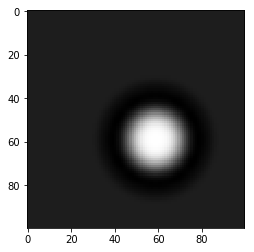

In [20]:
Grapher.show_image(DoG_stack[0][1][20,:,:])
Grapher.show_plot()

In [ ]:
print(ImageDrawer.x_range)

# Sandbox

In [ ]:

x = np.array([1,2,3])
y = np.zeros(3)
y[x < 2] = 1
y

In [ ]:
z = set(x) | set(y)
print(z)
print(x)
print(y)

In [ ]:

x = np.array(
    [[1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]]
)
[x for x in range(-1,2,2)]

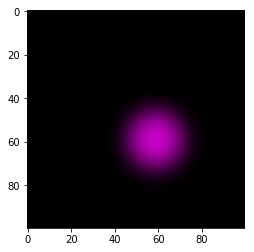

In [12]:
Grapher.show_image(rgb_img_centered[20,:,:])
Grapher.show_plot()

In [ ]:
x = np.zeros((3,3))
x[0,0] = 1
y = np.zeros((3,3))
y[0,0] = 1
np.logical_and(x, y)

In [ ]:
indices = np.argwhere(x == 0)
n,m = indices.shape
for i in range(n):
    print(tuple(indices[i,:]))

In [ ]:
z = set()
z.add(1)
z.add(1)
z

In [ ]:
x = np.array([1.0,2.0])
np.int(x)
x